# REINFORCE in lasagne (3 pts)

Just like we did before for q-learning, this time we'll design a lasagne network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from Seminar4.0, so you'll find it more or less familiar and even simpler.

__Frameworks__ - we'll accept this homework in any deep learning framework. For example, it translates to TensorFlow almost line-to-line. However, we recommend you to stick to theano/lasagne unless you're certain about your skills in the framework of your choice.

In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'
Starting virtual X frame buffer: Xvfb.
env: DISPLAY=:1


[2017-05-11 19:20:52,100] Making new env: CartPole-v0


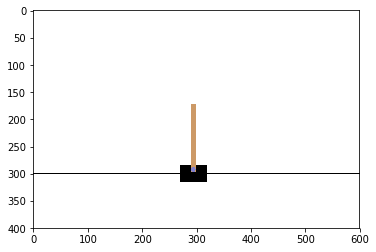

In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

In [3]:
import theano
import theano.tensor as T

#create input variables. We'll support multiple states at once

states = T.matrix("states[batch,units]")
actions = T.ivector("action_ids[batch]")
cumulative_rewards = T.vector("R[batch] = r + gamma*r' + gamma^2*r'' + ...")

In [4]:
import lasagne
from lasagne.layers import *

#input layer
l_states = InputLayer((None,)+state_dim,input_var=states)


nn = lasagne.layers.DenseLayer(l_states, 100, nonlinearity=lasagne.nonlinearities.elu)
nn = lasagne.layers.DenseLayer(nn, 50,  nonlinearity=lasagne.nonlinearities.elu)

#output layer
#this time we need to predict action probabilities,
#so make sure your nonlinearity forces p>0 and sum_p = 1
l_action_probas = DenseLayer(nn, num_units=n_actions,
                             nonlinearity=lasagne.nonlinearities.softmax)

#### Predict function

In [5]:
#get probabilities of actions
predicted_probas = get_output(l_action_probas)

#predict action probability given state
#if you use float32, set allow_input_downcast=True
predict_proba =  theano.function([states], predicted_probas, allow_input_downcast=True)

#### Loss function and updates

We now need to define objective and update over policy gradient.

The objective function can be defined thusly:

$$ J \approx \sum  _i log \pi_\theta (a_i | s_i) \cdot R(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [6]:
#select probabilities for chosen actions, pi(a_i|s_i)
predicted_probas_for_actions = predicted_probas[T.arange(actions.shape[0]),actions]

In [7]:
#REINFORCE objective function
J = T.mean(T.log(predicted_probas_for_actions) * cumulative_rewards)

In [8]:
#all network weights
all_weights = get_all_params(l_action_probas)

#weight updates. maximize J = minimize -J
updates = lasagne.updates.sgd(-J,all_weights,learning_rate=0.01)

In [9]:
train_step = theano.function([states,actions,cumulative_rewards],updates=updates,
                             allow_input_downcast=True)

### Computing cumulative rewards

In [10]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    
    cum_rewards = [rewards[-1]]
    for el in rewards[-2::-1]:
        cum_rewards.append(el + cum_rewards[-1] * gamma)
    return cum_rewards[::-1]

In [11]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


### Playing the game

In [12]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""
    
    #arrays to record session
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = predict_proba([s])[0] 
        
        a = np.random.choice(np.arange(n_actions), p=action_probas)
        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    cumulative_rewards = get_cumulative_rewards(rewards)
    train_step(states,actions,cumulative_rewards)
            
    return sum(rewards)

In [13]:
for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break

mean reward:20.900
mean reward:35.860
mean reward:50.820
mean reward:88.550
mean reward:132.080
mean reward:165.890
mean reward:193.790
mean reward:166.510
mean reward:120.910
mean reward:98.450
mean reward:236.340
mean reward:280.410
mean reward:317.610
You Win!


### Video

In [14]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


[2017-05-11 19:22:20,319] Making new env: CartPole-v0
[2017-05-11 19:22:20,325] Creating monitor directory videos
[2017-05-11 19:22:20,332] Starting new video recorder writing to /home/mlevkov/rl/Practical_RL/week6/videos/openaigym.video.0.594478.video000000.mp4
[2017-05-11 19:22:21,067] Starting new video recorder writing to /home/mlevkov/rl/Practical_RL/week6/videos/openaigym.video.0.594478.video000001.mp4
[2017-05-11 19:22:21,424] Starting new video recorder writing to /home/mlevkov/rl/Practical_RL/week6/videos/openaigym.video.0.594478.video000008.mp4
[2017-05-11 19:22:21,970] Starting new video recorder writing to /home/mlevkov/rl/Practical_RL/week6/videos/openaigym.video.0.594478.video000027.mp4
[2017-05-11 19:22:22,424] Starting new video recorder writing to /home/mlevkov/rl/Practical_RL/week6/videos/openaigym.video.0.594478.video000064.mp4
[2017-05-11 19:22:22,895] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/mlevkov/rl/Practical_RL/week6

In [15]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices